In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import softmax
import pandas as pd
import geopandas as gpd
import tqdm
import pickle
from scipy.spatial.distance import cdist
from shapely.geometry import Point

import os
import imageio
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plots

### Import census data

In [6]:
# MSOA polygons
polyMSOA = gpd.read_file('connectivity_data/Middle_Layer_Super_Output_Areas_December_2011_Full_Clipped_Boundaries_in_England_and_Wales/Middle_Layer_Super_Output_Areas_December_2011_Full_Clipped_Boundaries_in_England_and_Wales.shp')
polyMSOA = polyMSOA.set_index('msoa11cd')
polyMSOA = polyMSOA.drop(polyMSOA[polyMSOA.index == 'E02006781'].index) # remove scilly isles
polyMSOA = polyMSOA.sort_index()
n_MSOAs = len(polyMSOA)

# LSOA polygons
polyLSOA = gpd.read_file('connectivity_data/Lower_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BFC/Lower_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BFC.shp')
polyLSOA = polyLSOA.set_index('LSOA11CD')
polyLSOA = polyLSOA.sort_index()
polyLSOA = polyLSOA.to_crs(polyMSOA.crs)
n_LSOAs = len(polyLSOA)

In [7]:
# MSOA population data
popMSOA = pd.read_excel('connectivity_data/mid2011msoaquinaryageestimates.xls', sheet_name=1, header=3)
popMSOA = popMSOA[popMSOA['Unnamed: 2'].notna()]
popMSOA = popMSOA.drop(popMSOA[popMSOA['Area Codes'] == 'E02006781'].index) # remove scilly isles
popMSOA = popMSOA.set_index('Area Codes')
popMSOA = popMSOA.sort_index()

# LSOA population data
popLSOA = pd.read_excel('connectivity_data/mid-2011-lsoa-quinary-estimates.xls', sheet_name=1, header=3)
popLSOA = popLSOA[popLSOA['Unnamed: 2'].notna()]
popLSOA = popLSOA.set_index('Area Codes')
popLSOA = popLSOA.sort_index()

In [10]:
# commuter flow
commuter_flow = pd.read_csv('connectivity_data/wu03ew_v2.csv', header=0)
commuter_flow = commuter_flow.drop(commuter_flow[commuter_flow['Area of residence'] == 'E02006781'].index) # remove scilly
commuter_flow = commuter_flow.drop(commuter_flow[commuter_flow['Area of workplace'] == 'E02006781'].index) # remove scilly

# take all categories of travel only for the flow data
commuter_flow = commuter_flow[['Area of residence',
             'Area of workplace',
             'All categories: Method of travel to work']]

# make sure all workplaces are residence areas and vice versa
commuter_flow = commuter_flow[commuter_flow['Area of workplace'].isin(commuter_flow['Area of residence'])]

# pivot into a matrix
commuter_flow = commuter_flow.pivot_table(columns='Area of residence',
                 index='Area of workplace',
                 values='All categories: Method of travel to work').fillna(value=0)

# MSOA flow data is ready for use
commuter_flow = commuter_flow.values.T

### Import schools data

In [11]:
# load schools csv - oly some columns to avoid bugs
schools = pd.read_csv(os.path.join('connectivity_data/schools_UK.csv'),
                      usecols=['StatutoryLowAge', 'StatutoryHighAge', 'Postcode', 'Easting', 'Northing'])
primary_schools = schools[schools['StatutoryHighAge'] <= 11]
secondary_schools = schools[schools['StatutoryHighAge'] > 11]

# make a column of Point objects of longlat coordinates
schools['point']=[Point(east, north) for (east, north) in zip (schools.Easting.values, schools.Northing.values)]
primary_schools['point']=[Point(east, north) for (east, north) in zip (primary_schools.Easting.values, primary_schools.Northing.values)]
secondary_schools['point']=[Point(east, north) for (east, north) in zip (secondary_schools.Easting.values, secondary_schools.Northing.values)]

# make a geopandas dataframe object from the dataframe
schools_gdf = gpd.GeoDataFrame(schools, geometry='point')

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


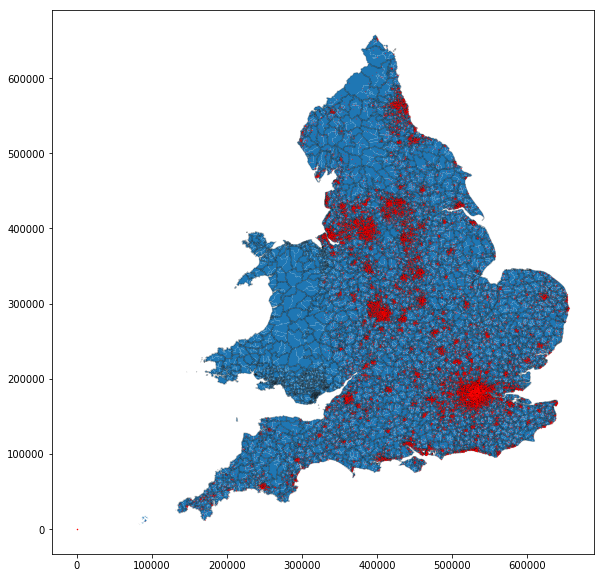

In [12]:
# have a look at the map to check it looks reaosnable
fig, ax = plt.subplots(1, figsize = (10,10))
polyLSOA.plot(ax=ax);
polyMSOA.plot(color='None', edgecolor='k', ax=ax, alpha=.2);
schools_gdf.plot(markersize=.01, color='red', ax=ax);

In [13]:
# spatial centroids of MSOAS
pointsMSOA = polyMSOA.copy()
pointsMSOA.geometry = pointsMSOA['geometry'].centroid
pointsMSOA.crs = polyMSOA.crs
node_positions_MSOA = pointsMSOA.apply(lambda x: np.array(x['geometry']), axis=1)

# spatial centroids of LSOAS
pointsLSOA = polyLSOA.copy()
pointsLSOA.geometry = pointsLSOA['geometry'].centroid
pointsLSOA.crs = polyLSOA.crs
node_positions_LSOA = pointsLSOA.apply(lambda x: np.array(x['geometry']), axis=1)

In [ ]:
# which MSOA is each LSOA in?
parent_MSOA = np.zeros(n_LSOAs)

for i, pt in tqdm.tqdm(enumerate(pointsLSOA['geometry']), total=len(pointsLSOA)):
    for j, py in enumerate(polyMSOA['geometry'].values):
        if pt.within(py):
            parent_MSOA[i] = j
            break

 72%|███████▏  | 25135/34753 [07:06<05:17, 30.32it/s]

In [ ]:
# create lists of LSOAs in each MSOA
LSOAs_in_MSOA = []
for i in tqdm.tqdm(range(n_MSOAs)):
    LSOAs_in_MSOA.append(np.where(parent_MSOA == i)[0])

In [ ]:
# put schools into LSOAs

# where does England end and Wales begin?
country = np.array([polyLSOA.index.values[i][0] for i in range(len(polyLSOA.index.values))])
wales = min(np.where(country == 'W')[0])

# put English primary schools into MSOAs
primary_schools_per_LSOA = np.zeros(n_LSOAs)
for i, pt in tqdm.tqdm(enumerate(primary_schools['point']), total=len(primary_schools)):
    for j, py in enumerate(polyLSOA['geometry'].values):
        if pt.within(py):
            primary_schools_per_LSOA[j] += 1
            break
            
# put English secondary schools into MSOAs
secondary_schools_per_LSOA = np.zeros(n_LSOAs)
for i, pt in tqdm.tqdm(enumerate(secondary_schools['point']), total=len(secondary_schools)):
    for j, py in enumerate(polyLSOA['geometry'].values):
        if pt.within(py):
            secondary_schools_per_LSOA[j] += 1
            break

# randomly place schools in LSOAs based on population of school kids for Wales
primary_school_population_LSOA = np.floor(popLSOA['5-9'].values + 0.25*popLSOA['10-14'].values)
secondary_school_population_LSOA = np.floor(0.75*popLSOA['10-14'].values + 0.5*popLSOA['15-19'].values)
n_primary_schools = 1238
n_secondary_schools = 187
primary_schools_per_LSOA[wales:] = np.random.multinomial(n_primary_schools, pvals=primary_school_population_LSOA[wales:]/np.sum(primary_school_population_LSOA[wales:]))
secondary_schools_per_LSOA[wales:] = np.random.multinomial(n_secondary_schools, pvals=secondary_school_population_LSOA[wales:]/np.sum(secondary_school_population_LSOA[wales:]))

In [ ]:
# distances between MSOAs and LSOAs
LSOA_positions = np.array([np.array(pt) for pt in pointsLSOA.geometry.values])
distances_LSOA = cdist(LSOA_positions, LSOA_positions)

MSOA_positions = np.array([np.array(pt) for pt in pointsMSOA.geometry.values])
distances_MSOA = cdist(MSOA_positions, MSOA_positions)

In [ ]:
# k nearest schools
k = 6

# flow from i -> j
primary_school_flow_LSOA = np.zeros((n_LSOAs, n_LSOAs))

# loop over LSOAs
for i in tqdm.tqdm(range(n_LSOAs)):

    # args for sorted distances
    sorted_args = np.argsort(distances_LSOA[i,:])

    # sorted distances and number of schools per LSOA (incl cumulative number fo schools with increasing distance)
    dist = distances_LSOA[i,sorted_args]
    num_schools = primary_schools_per_LSOA[sorted_args]
    cumulative_num_schools = np.cumsum(num_schools)

    # now choose the neighbouring LSOAs that contain the nearest k schools
    if cumulative_num_schools[0] > k:
        cutoff = 1
    else:
        cutoff = np.max(np.where(cumulative_num_schools <= k)) + 1
    num_schools = num_schools[:cutoff+1]
    args = sorted_args[:cutoff+1]
    weights = num_schools/np.sum(num_schools)
    
    primary_school_flow_LSOA[i,args] = np.random.multinomial(primary_school_population_LSOA[i], pvals=weights)
    

# flow from i -> j
secondary_school_flow_LSOA = np.zeros((n_LSOAs, n_LSOAs))

# loop over LSOAs
for i in tqdm.tqdm(range(n_LSOAs)):

    # args for sorted distances
    sorted_args = np.argsort(distances_LSOA[i,:])

    # sorted distances and number of schools per LSOA (incl cumulative number fo schools with increasing distance)
    dist = distances_LSOA[i,sorted_args]
    num_schools = secondary_schools_per_LSOA[sorted_args]
    cumulative_num_schools = np.cumsum(num_schools)

    # now choose the neighbouring LSOAs that contain the nearest k schools
    if cumulative_num_schools[0] > k:
        cutoff = 1
    else:
        cutoff = np.max(np.where(cumulative_num_schools <= k)) + 1
    num_schools = num_schools[:cutoff+1]
    args = sorted_args[:cutoff+1]
    weights = num_schools/np.sum(num_schools)
    
    secondary_school_flow_LSOA[i,args] = np.random.multinomial(secondary_school_population_LSOA[i], pvals=weights)

In [ ]:
# downsample the LSOA schools flow to MSOA level flows
school_flow_MSOA = np.zeros((n_MSOAs, n_MSOAs))

for i in tqdm.tqdm(range(n_MSOAs)):
    
    # pick out LSOAs belonging to this MSOA
    LSOAs = LSOAs_in_MSOA[i]
    
    flow = np.sum(primary_school_flow_LSOA[LSOAs,:] + secondary_school_flow_LSOA[LSOAs,:], axis=0)
    
    for j in range(n_LSOAs):
        school_flow_MSOA[i,int(parent_MSOA[j])] += flow[j]

In [ ]:
# rename for the next section
school_flow = school_flow_MSOA

### Make connectivity

In [ ]:
# split population into work, school, other
population = popMSOA['All Ages'].values
work_population = np.sum(commuter_flow, axis=1)
school_population = np.floor(popMSOA['5-9'].values + popMSOA['10-14'].values + 0.5*popMSOA['15-19'].values)
other_population = population - work_population - school_population

# areas of MSOAs
areas = polyMSOA['st_areasha'].values

# fix diagonals of MSOA distances (for the self terms in the gravity law model)
distances_MSOA[np.diag_indices(n_MSOAs)] = np.sqrt(areas)/2

In [ ]:
# occupation (work, school, other) probabilities for each community
p_occupation = np.zeros((n_MSOAs, 3))
p_occupation[:,0] = school_population / population
p_occupation[:,1] = work_population / population
p_occupation[:,2] = other_population / population

# working location probabilities for each community
p_workplace = np.zeros((n_MSOAs, n_MSOAs))
p_school = np.zeros((n_MSOAs, n_MSOAs))
for i in range(n_MSOAs):
    p_workplace[i,:] = commuter_flow[i,:]/np.sum(commuter_flow[i,:])
    p_school[i,:] = school_flow[i,:]/np.sum(school_flow[i,:])

# home interaction term (identity matrix)
home_interaction = np.eye(n_MSOAs)

In [ ]:
# worktime populations in each community (ie, the total number of people who come there to work from anywhere)
worktime_population = np.sum(commuter_flow, axis=0)

In [ ]:
# gravity model terms based on work-time (daytime) and raw populations
gravity_worktime = np.outer(worktime_population, worktime_population)/distances_MSOA**2
gravity_raw = np.outer(population, population)/distances_MSOA**2

gravity_worktime = gravity_worktime/np.sum(gravity_worktime, axis=1)
gravity_raw = gravity_raw/np.sum(gravity_raw, axis=1)

In [ ]:
# interaction terms

# school and work interaction terms (assume commuters interact only with other commuters)
# interaction[A, B] is the fraction of interactions a node will have with people from B while working/at school in A
school_occupancy = np.zeros((n_MSOAs, n_MSOAs))
work_occupancy = np.zeros((n_MSOAs, n_MSOAs))
for i in range(n_MSOAs):
    school_occupancy[:,i] = school_flow[:,i]/np.sum(school_flow[:,i])
    work_occupancy[:,i] = commuter_flow[:,i]/np.sum(commuter_flow[:,i])
school_occupancy[np.isnan(school_occupancy)] = 0

# flows due to gravity model and occupancy of communities based on people moving about according to gravity model
gravity_flow = np.zeros((n_MSOAs, n_MSOAs))
for i in tqdm.tqdm_notebook(range(n_MSOAs)):
    gravity_flow[i,:] = np.random.multinomial(population[i], gravity_worktime[i,:]/np.sum(gravity_worktime[i,:]))
    
# relative occupancy of each community when everyone is moving about according to gravity model
gravity_occupancy = np.zeros((n_MSOAs, n_MSOAs))
for i in range(n_MSOAs):
    # occupancy[j, i] = frac of ppl who are from j out of all the people who find themselves in i
    gravity_occupancy[:,i] = gravity_flow[:,i]/np.sum(gravity_flow[:,i])

# interaction terms
# X_interaction[A,B] is the fraction of interactions you will have with people from B given that you live in A, assuming that everyone is moving about according to a gravity model at this time
gravity_interaction = np.zeros((n_MSOAs, n_MSOAs))
school_interaction = np.zeros((n_MSOAs, n_MSOAs))
work_interaction = np.zeros((n_MSOAs, n_MSOAs))
for i in tqdm.tqdm_notebook(range(n_MSOAs)):
    
    gravity_interaction[i,:] = np.dot( gravity_occupancy, gravity_worktime[i,:] )
    gravity_interaction[i,:] = gravity_interaction[i,:] / np.sum(gravity_interaction[i,:])
    
    school_interaction[i,:] = np.dot( school_occupancy, p_school[i,:] )
    school_interaction[i,:] = school_interaction[i,:] / np.sum(school_interaction[i,:])
    
    work_interaction[i,:] = np.dot( work_occupancy, p_workplace[i,:] )
    work_interaction[i,:] = work_interaction[i,:] / np.sum(work_interaction[i,:])

In [ ]:
# pickle the model components
f = open('connectivity_model/three_part_connectivity_model_with_school_data.pkl', 'wb')
pickle.dump([school_occupancy, work_occupancy, home_interaction, gravity_interaction, p_school, p_workplace, p_occupation], f)
f.close()